In [39]:
import jax 
import jax.numpy as jnp 
import flax.linen as nn 
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import optax
from sklearn.metrics import mean_squared_error as mse

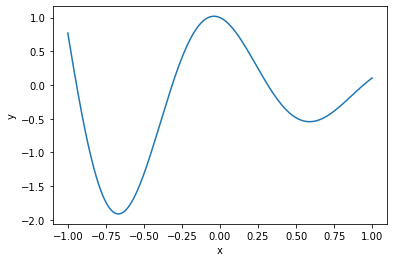

In [83]:
# function to approximate 
def f(x):
    return jnp.cos(5*jnp.prod(x, axis=1))*jnp.exp(-x[:,0])

# example in one dimension
x = jnp.linspace(-1,1,1000).reshape(-1,1)
y = f(x)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [84]:
class Regression(nn.Module):
    num_features: int
    
    def setup(self):
        self.w = self.param('weights', jax.nn.initializers.glorot_uniform(),
                                (self.num_features,1))
    @nn.compact
    def __call__(self, x):
        print(x.shape, self.w.shape)
        out = jnp.sum(x*self.w[:,0], axis=1)
        print(out.shape)
        return out
# initializing the optimizer
learning_rate = 1e-3
optx = optax.adam(learning_rate=learning_rate)
# A function to generate polynomial features - equivalent to fitting using a polynomial 
def generate_poly(deg_poly, x):
    poly = PolynomialFeatures(deg_poly)
    return poly.fit_transform(x)


## Fitting a function in one dimension

In [85]:
#training data
x = jnp.linspace(-1,1,10000).reshape(-1,1)
y = f(x)

deg_poly = 50 #degree of the polynomial
x_poly = generate_poly(deg_poly, x)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.33, random_state=42)

# initialize the neural network 
model = Regression(deg_poly + 1)
params = model.init(jax.random.PRNGKey(0), x_test)
opt_state = optx.init(params)

# define the loss function 
@jax.jit
def MSE(params, x, y_true):
    y_pred = model.apply(params, x)
    return jnp.mean((y_pred-y_true)**2)

loss_fn = MSE
loss_grad_fn = jax.value_and_grad(MSE) # a function to evaluate the function and its gradient)

# training loop
n_epochs = 10000 #number of training epochs 
for e in range(n_epochs):
    loss_val, grad = loss_grad_fn(params, x_train, y_train)
    updates, opt_state = optx.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    if e % 500 == 0:
        print(f"epoch: {e}, loss function: {loss_val}")

(3300, 51) (51, 1)
(3300,)
(6700, 51) (51, 1)
(6700,)
epoch: 0, loss function: 0.8350861072540283
epoch: 500, loss function: 0.49023446440696716
epoch: 1000, loss function: 0.37670081853866577
epoch: 1500, loss function: 0.31107279658317566
epoch: 2000, loss function: 0.2660868763923645
epoch: 2500, loss function: 0.22958408296108246
epoch: 3000, loss function: 0.19759507477283478
epoch: 3500, loss function: 0.1696707010269165
epoch: 4000, loss function: 0.1459038257598877
epoch: 4500, loss function: 0.12619870901107788
epoch: 5000, loss function: 0.11016121506690979
epoch: 5500, loss function: 0.09709593653678894
epoch: 6000, loss function: 0.0861077606678009
epoch: 6500, loss function: 0.07634896785020828
epoch: 7000, loss function: 0.06728615611791611
epoch: 7500, loss function: 0.05874565616250038
epoch: 8000, loss function: 0.05076410993933678
epoch: 8500, loss function: 0.043439749628305435
epoch: 9000, loss function: 0.03685823827981949
epoch: 9500, loss function: 0.031072597950

We now evaluate the training and test error. Does the model suffer from overfitting? from underfitting? from both?

(3300, 51) (51, 1)
(3300,)
training error: 0.026101306080818176, test error: 0.02636314556002617
(10000, 51) (51, 1)
(10000,)


Text(0.5, 1.0, 'Functions on all data')

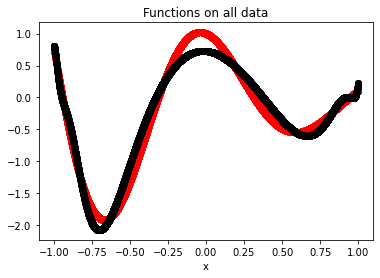

In [86]:
# evaluate the training and test errors 
tr_error = MSE(params, x_train, y_train)
te_error = MSE(params, x_test, y_test)
print(f"training error: {tr_error}, test error: {te_error}")
y_pred = model.apply(params, x_poly)
# plotting the true and predicted signal on training data 
plt.plot(x, y, marker='o', color='r', label="True function")
plt.plot(x, y_pred, marker='o', color='black', label="Approximate function")
plt.xlabel('x')
plt.title("Functions on all data")

An important question here is how many 